<a href="https://colab.research.google.com/github/mebirtukan/EyeMovementEventDetectionAlgorithms/blob/main/RF_Event_Classifi_iynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import  TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from sklearn.metrics import f1_score 

import os
import glob
import seaborn as sns

In [ ]:
!wget www.kasprowski.pl/datasets/events.zip
!unzip events.zip > xx

--2022-10-31 12:42:02--  http://www.kasprowski.pl/datasets/events.zip
Resolving www.kasprowski.pl (www.kasprowski.pl)... 94.152.164.213
Connecting to www.kasprowski.pl (www.kasprowski.pl)|94.152.164.213|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2909538 (2.8M) [application/zip]
Saving to: ‘events.zip’

events.zip          100%[===================>]   2.77M  2.74MB/s    in 1.0s    

2022-10-31 12:42:03 (2.74 MB/s) - ‘events.zip’ saved [2909538/2909538]



In [ ]:
def openfile(filename):
  mat = loadmat(filename)
  mdata = mat['ETdata']
  mtype = mdata.dtype
  ndata = {n: mdata[n][0,0] for n in mtype.names}
  data_headline = ndata['pos']
  data_headline = data_headline[0]
  data_raw = ndata['pos']
  pdata = pd.DataFrame(data_raw,columns=data_headline)
  df=pd.DataFrame(pdata)
  df[1.0]=df[1.0].astype(int)
  #t=pdata.iloc[:, 0].values maybe we should use it...
  x=pdata.iloc[:, 3:5].values
  y=pdata.iloc[:, 5].values
  print("File",filename,"opened")
  return x ,y

In [ ]:
# data has two coordinates: X,Y returns velX and velY
def calc_xy_velocity(data):
  velX = [] #x values difference
  velY = [] #y values difference 

  for i in range(len(data) - 1):
    velX.append(float(data[i+1,0]) - float(data[i,0]) ) # 2ms!
    velY.append(float(data[i+1,1]) - float(data[i,1]) )
  velX = np.array(velX)
  velY = np.array(velY)
  velocity = np.vstack([velX,velY]).T
  return velocity

# data has two coordinates: X,Y returns ONE velocity
def calc_velocity(data):
  velX = [] #x values difference
  velY = [] #y values difference 
  for i in range(len(data) - 1):
    velX.append(float(data[i+1,0]) - float(data[i,0]) ) # 2ms!
    velY.append(float(data[i+1,1]) - float(data[i,1]) )
  velX = np.array(velX)
  velY = np.array(velY)
  velocity = np.sqrt(np.power(velX,2) + np.power(velY,2))
  print(velocity.shape)  
  return velocity

In [ ]:


def open_list_of_files(files_to_load):
  samples = []
  labels =[]
  for my_file in files_to_load:
    sam,lab = openfile(my_file)
    #ssam,slab = make_sequences(sam,lab,50)
    print('Number of samples so far:',len(samples))
    samples.extend(sam)
    labels.extend(lab)
  samples = np.array(samples)
  labels = np.array(labels)
  print('Number of samples at the end:',len(samples))
  return samples,labels
files_to_load1 = ['data/UH33_img_vy_labelled_MN.mat','data/UH47_img_Europe_labelled_MN.mat','data/UH47_img_Europe_labelled_RA.mat','data/UH21_img_Rome_labelled_MN.mat', 'data/UH27_img_vy_labelled_MN.mat']
#files_to_load = ['data/TH34_img_Europe_labelled_MN.mat', 'data/UH21_img_Rome_labelled_RA.mat']
files_to_load = ['data/TH34_img_Europe_labelled_MN.mat', 'data/UH21_img_Rome_labelled_MN.mat']

#files_to_load = ['data/UH21_img_Rome_labelled_MN.mat']
#files_to_load1 = ['data/TH34_img_Europe_labelled_MN.mat']

s,l = open_list_of_files(files_to_load)
s1,l1=open_list_of_files(files_to_load1)
print(s.shape)
print(l.shape)
print(s1.shape)
print(l1.shape)

File data/TH34_img_Europe_labelled_MN.mat opened
Number of samples so far: 0
File data/UH21_img_Rome_labelled_RA.mat opened
Number of samples so far: 4988
Number of samples at the end: 9976
File data/UH33_img_vy_labelled_MN.mat opened
Number of samples so far: 0
File data/UH47_img_Europe_labelled_MN.mat opened
Number of samples so far: 4988
File data/UH47_img_Europe_labelled_RA.mat opened
Number of samples so far: 6985
File data/UH21_img_Rome_labelled_MN.mat opened
Number of samples so far: 8982
File data/UH27_img_vy_labelled_MN.mat opened
Number of samples so far: 13970
Number of samples at the end: 18958
(9976, 2)
(9976,)
(18958, 2)
(18958,)


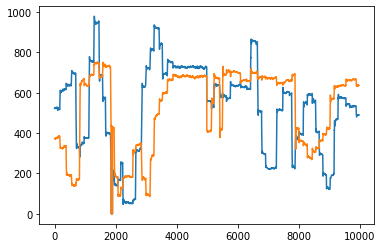

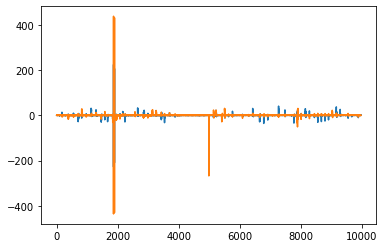

In [ ]:
# simple visualization
plt.plot(s)
plt.show()
s = calc_velocity(s)
s1 = calc_velocity(s1)
plt.plot(s)

In [ ]:
# sequence 
def make_sequences(samples, labels, sequence_dim = 100, sequence_lag = 1, sequence_attributes = 2):
    nsamples = []
    nlabels = [] 
    for i in range(0,samples.shape[0]-sequence_dim,sequence_lag):
            nsample = np.zeros((sequence_dim,sequence_attributes))
            for j in range(i,i+sequence_dim):
                nsample[j-i,0] = samples[j,0]
                nsample[j-i,1] = samples[j,1]
            nlabel = labels[i+sequence_dim//2]
            nsamples.append(nsample)
            nlabels.append(nlabel)
        
    samples = np.array(nsamples)
    labels = np.array(nlabels)
    return samples,labels 

In [ ]:
sequence_dim = 15
print("Converting to sequences of length {}".format(sequence_dim))
x,y = make_sequences(s, l, sequence_dim)
x1,y1 = make_sequences(s1, l1, sequence_dim)
print("done:",x.shape )

Converting to sequences of length 15
done: (9960, 15, 2)


In [ ]:
x = x.reshape(-1, sequence_dim*2)
x1 = x1.reshape(-1, sequence_dim*2)

x.shape

(9960, 30)

In [ ]:
from sklearn import ensemble
from sklearn.metrics import classification_report, confusion_matrix
#RF=OneVsRestClassifier(RandomForestClassifier(max_features=0.2))
RF=ensemble.RandomForestClassifier()

# from sklearn.neighbors import KNeighborsClassifier
# RF = KNeighborsClassifier(n_neighbors=5)
RF.fit(x, y)
y1_pred=RF.predict(x1)
print(classification_report(y1, y1_pred))
print(confusion_matrix(y1, y1_pred))
CM=confusion_matrix(y1, y1_pred)
sumf=CM[0][0]+CM[0][1]+CM[0][2]
#print(sum)
Tcf=CM[0][0]
Fixa_recall=Tcf*100/sumf
print("Fixa_recall",Fixa_recall)
#fixation precision 
sumfp=CM[0][0]+CM[1][0]+CM[2][0]
Tcfp=CM[0][0]
fixation_precision=(Tcfp*100/sumfp)
#print('Fixation precission', fixation_precision)
 #fixation f1_score
multiply_recal_prec=2*((Tcfp*100/sumfp)*(Tcf*100/sumf))
add_recall_prec=((Tcf*100/sumf)+Tcfp*100/sumfp)
result_f1_score=multiply_recal_prec/add_recall_prec
fixation_f1_score=(result_f1_score)
#print('fixation_f1_score', fixation_f1_score)
#Saccade recall
sum_sac=CM[1][0]+CM[1][1]+CM[1][2]
Tc_sac=CM[1][1]
Sacc_recall=(Tc_sac*100/sum_sac)
print("Sacc_recall",Sacc_recall)
#Saccade precison
sum_saccP=CM[0][1]+CM[1][1]+CM[2][2]
Tc_saccP=CM[1][1]
saccade_precision=(Tc_saccP*100/sum_saccP)
#print('saccade_precision', saccade_precision)
 #saccade f1_score
multiply=2*((Tc_saccP*100/sum_saccP)*(Tc_sac*100/sum_sac))
addition=(Tc_sac*100/sum_sac)+(Tc_saccP*100/sum_saccP)
saccade_f1_score=(multiply/addition)
#print('saccade_f1_score', saccade_f1_score)
  #PSO Reacll
sum_PSO=CM[2][0]+CM[2][1]+CM[2][2]
#print(sum)
Tc_PSO=CM[2][2]
PSO_Recall=Tc_PSO*100/sum_PSO
print("PSO_Recall",PSO_Recall)
#PSO precission
sum_PSP_precison=CM[0][2]+CM[1][2]+CM[2][2]
Tc_PSO_P=CM[2][2]
PSO_Precision=(Tc_PSO_P*100/sum_PSP_precison)
#print('PSO_Precision', PSO_Precision)
 #PSO f1_score
multiply=2*((Tc_PSO_P*100/sum_PSP_precison)*(Tc_PSO*100/sum_PSO))
adition=(Tc_PSO*100/sum_PSO)+(Tc_PSO_P*100/sum_PSP_precison)
PSO_f1_score=(multiply/addition)
#print('PSO_f1_score', PSO_f1_score)
  

              precision    recall  f1-score   support

           1       0.99      0.97      0.98     15946
           2       0.87      0.91      0.89      1830
           3       0.62      0.76      0.68      1166

    accuracy                           0.95     18942
   macro avg       0.83      0.88      0.85     18942
weighted avg       0.96      0.95      0.95     18942

[[15444    43   459]
 [   77  1659    94]
 [   83   199   884]]
Fixa_recall 96.85187507838957
Sacc_recall 90.65573770491804
PSO_Recall 75.8147512864494


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score
print(cohen_kappa_score(y1, y1_pred))


0.8274280923434728


In [ ]:
y1_pred

array([1, 1, 1, ..., 2, 2, 2])

[[0.97 0.   0.03]
 [0.04 0.91 0.05]
 [0.07 0.17 0.76]]


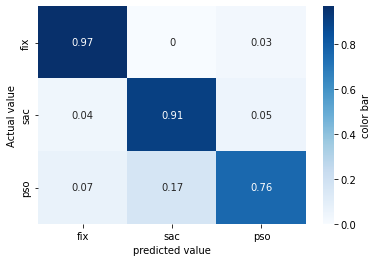

In [ ]:
cm_normalized=np.round(CM/np.sum(CM, axis=1).reshape(-1, 1), 2)
print(cm_normalized)
sns.heatmap(cm_normalized, cmap='Blues', annot=True, cbar_kws={"orientation": "vertical", "label": "color bar"}, xticklabels=['fix','sac','pso'], yticklabels=['fix', 'sac', 'pso'])
plt.xlabel("predicted value")
plt.ylabel("Actual value")
plt.show()